In [1]:
# !pip install matplotlib jaxlib equinox wandb

In [2]:
import os
import wandb

os.environ["WANDB_API_KEY"] = ""
wandb.init(project="HN")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pre63. Use `wandb login --relogin` to force relogin


In [3]:
# Standard imports
import math
from typing import List

# JAX imports
import jax
from jax import numpy as jnp
import jax.lax as lax
import jax.random as jrandom
import jax.random as jr

# Equinox import
import equinox as eqx

# WandB import
import wandb

# Matplotlib import
import matplotlib.pyplot as plt

# Dataclass import
from dataclasses import dataclass


In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [5]:
key = jax.random.PRNGKey(2000)

In [6]:
key, subkey1, subkey2 = jax.random.split(key, 3)

data_set_size = 2_000
data = jnp.concatenate((-0.5 + 0.2 * jax.random.normal(subkey1, (int(data_set_size * 1/5), 2)),
                         0.5 + 0.2 * jax.random.normal(subkey2, (int(data_set_size * 4/5), 2))), axis=0)

print(data.shape)

# Set the number of projections
num_projections = 2

# Generate random projection vectors
key, subkey = jax.random.split(key)
projection_vectors = jax.random.normal(subkey, (num_projections, data.shape[1]))

# Normalize the projection vectors
projection_vectors /= jnp.linalg.norm(projection_vectors, axis=1, keepdims=True)

# Project data onto each random vector
data = [jnp.dot(data, v) for v in projection_vectors]

data = jnp.stack(data, axis=1)

print(data.shape)

(2000, 2)
(2000, 2)


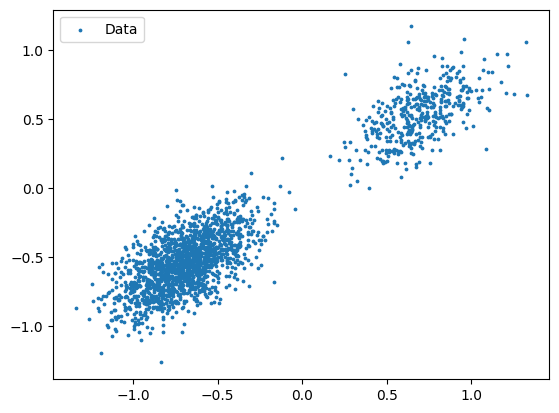

In [7]:
plt.scatter(data[:, 0], data[:, 1], s=3, label="Data")
plt.legend()
plt.show()

## Training


In [8]:

from flowMC.nfmodel.realNVP import RealNVP
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline

import optax  # Optimizers

In [9]:
# Model parameters
n_feature = 2
n_layers = 10
n_hidden = 100


model = RealNVP(
    n_feature,
    n_layers,
    n_hidden,
    subkey1,
    data_mean=jnp.mean(data, axis=0),
    data_cov=jnp.cov(data.T),
)

In [10]:
# Optimization parameters
num_epochs = 100
batch_size = 10000
learning_rate = 0.001
momentum = 0.9

optim = optax.adam(learning_rate)
state = optim.init(eqx.filter(model, eqx.is_array))
key, subkey = jax.random.split(key)
key, model, state, loss = model.train(key, data, optim, state, num_epochs, batch_size, verbose=True)

Training NF, current loss: 1.453: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


Text(0, 0.5, 'Loss')

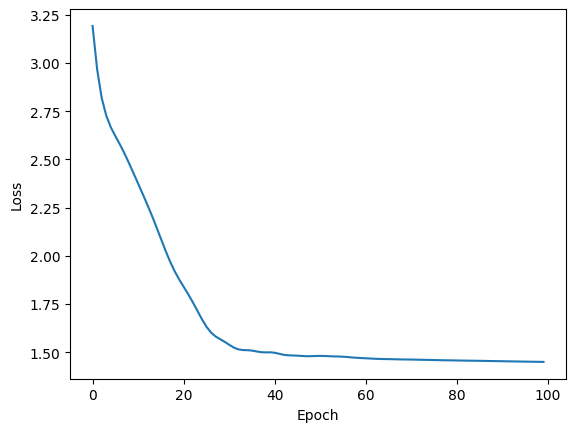

In [11]:
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

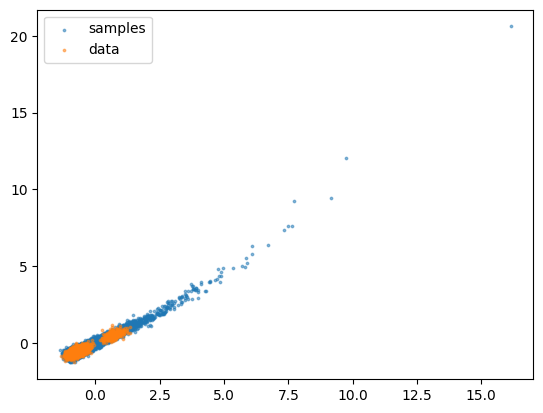

In [12]:
nf_samples = model.sample(subkey, 10000)
plt.figure()

plt.scatter(
    nf_samples[:, 0], nf_samples[:, 1], s=3, alpha=0.5, label="samples"
)

plt.scatter(data[:, 0], data[:, 1], s=3, alpha=0.5, label="data")

plt.legend()
plt.show()

In [17]:
def ebm(x):
    return x

## Plotting the training history

In [18]:
def get_energy_map(model, density=100, val=1.6):
    xs = jnp.linspace(-val, val, density)
    ys = jnp.linspace(-val, val, density)
    X, Y = jnp.meshgrid(xs, ys)
    XY = jnp.stack([X, Y], axis=-1)
    XY = XY.reshape(-1, 2)
    f_vectorized = jax.vmap(model, in_axes=(0))
    Z = f_vectorized(XY)
    Z = Z.reshape(100, 100)
    return X, Y, Z

def get_score_map(model, density=30, val=1.6):
    xs = jnp.linspace(-val, val, density)
    ys = jnp.linspace(-val, val, density)
    X, Y = jnp.meshgrid(xs, ys)
    XY = jnp.stack([X, Y], axis=-1)
    XY = XY.reshape(-1, 2)
    f_vectorized = jax.vmap(jax.grad(lambda x: -1 * model(x)), in_axes=(0))
    Z = f_vectorized(XY)
    Z = Z.reshape(density, density, 2)

    return X, Y, Z

In [19]:
X, Y, Z = get_score_map(ebm)

plt.figure(figsize=(10, 10))
plt.quiver(X, Y, Z[:,:,0], Z[:,:,1], color='g')
plt.show()

TypeError: Gradient only defined for scalar-output functions. Output had shape: (2,).

In [20]:
X, Y, Z = get_energy_map(ebm)

plt.figure(figsize=(10, 10))
plt.contourf(X, Y, Z, 50, cmap='viridis')
plt.colorbar()
plt.show()

TypeError: cannot reshape array of shape (10000, 2) (size 20000) into shape (100, 100) (size 10000)